In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
class Pinn(nn.Module):
    def __init__(self):
        super(Pinn, self).__init__()
        self.loss_function = nn.MSELoss()
        self.layer_size = 80
        # self.PL_size = 1
        # self.space_dense = nn.Linear(2, self.PL_size*2) # input: [x, z]
        # self.periodic_layer = PeriodicLayer(dim_in=1, dim_out=self.PL_size) # input: [phi]
        self.dense_layers = nn.Sequential(
            nn.Linear(2, self.layer_size), # input: [x, z]
            # nn.Dropout(p=0.5),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            # nn.Dropout(p=0.5),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            # nn.Dropout(p=0.5),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            # nn.Dropout(p=0.5),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, self.layer_size),
            # nn.Dropout(p=0.5),
            nn.Sigmoid(),
            nn.Linear(self.layer_size, 6) # output: [Bpx, Bpz, Bphi, A, Aprime, Psi]
        )

    def forward(self, input):
        # phi = input[:,[0]]
        # xz = input[:,1:]
        # xz = self.space_dense(xz)
        # phi_per = self.periodic_layer(phi)
        # input = torch.cat((phi_per, xz),axis=1)
        out = self.dense_layers(input)
        return out

    def PDELoss(self, input):
        g = input.clone()
        # phi = g[:,[0]]
        x   = g[:,[0]]
        z   = g[:,[1]]
        out = self.forward(g)
        Bpx    = out[:,[0]]
        Bpz    = out[:,[1]]
        Bphi   = out[:,[2]]
        A      = out[:,[3]]
        Aprime = out[:,[4]]
        Psi    = out[:,[5]]

        Bpx_r    = torch.autograd.grad(Bpx,    g, torch.ones([input.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Bpz_r    = torch.autograd.grad(Bpz,    g, torch.ones([input.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Bphi_r   = torch.autograd.grad(Bphi,   g, torch.ones([input.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        A_r      = torch.autograd.grad(A,      g, torch.ones([input.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Aprime_r = torch.autograd.grad(Aprime, g, torch.ones([input.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Psi_r    = torch.autograd.grad(Psi,    g, torch.ones([input.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]

        Bpx_rr    = torch.autograd.grad(Bpx_r,    g, torch.ones(input.shape).to(device), create_graph=True)[0]
        Bpz_rr    = torch.autograd.grad(Bpz_r,    g, torch.ones(input.shape).to(device), create_graph=True)[0]
        Bphi_rr   = torch.autograd.grad(Bphi_r,   g, torch.ones(input.shape).to(device), create_graph=True)[0]
        A_rr      = torch.autograd.grad(A_r,      g, torch.ones(input.shape).to(device), create_graph=True)[0]
        Aprime_rr = torch.autograd.grad(Aprime_r, g, torch.ones(input.shape).to(device), create_graph=True)[0]
        Psi_rr    = torch.autograd.grad(Psi_r,    g, torch.ones(input.shape).to(device), create_graph=True)[0]

        Psi_x = Psi_r[:,[0]]
        Psi_z = Psi_r[:,[1]]
        A_x = A_r[:,[0]]
        A_z = A_r[:,[1]]
        Aprime_x = Aprime_r[:,[0]]
        Aprime_z = Aprime_r[:,[1]]

        Psi_xx = Psi_rr[:,[0]]
        Psi_zz = Psi_rr[:,[1]]
        A_xx = A_rr[:,[0]]

        Rlc = 1.0
    
        # Force Free 2D Equations
        eq1 = (1-x**2)*(Psi_xx - (1/x)*Psi_x + Psi_zz) - 2*x*Psi_x + Rlc**2*A*Aprime
        eq2 = Bpx + (1/(x*Rlc))*Psi_z
        eq3 = Bpz - (1/(x*Rlc))*Psi_x
        eq4 = Bphi - (1/(x*Rlc))*A
        eq5 = A_x - Aprime*Psi_x
        eq6 = A_z - Aprime*Psi_z

        loss1 = self.loss_function(eq1, torch.zeros_like(eq1))
        loss2 = self.loss_function(eq2, torch.zeros_like(eq2))
        loss3 = self.loss_function(eq3, torch.zeros_like(eq3))
        loss4 = self.loss_function(eq4, torch.zeros_like(eq4))
        loss5 = self.loss_function(eq5, torch.zeros_like(eq5))
        loss6 = self.loss_function(eq6, torch.zeros_like(eq6))

        return (loss1 + loss2 + loss3 + loss4 + loss5 + loss6)

    def BCLoss_x0z(self, input_bc):
        out = self.forward(input_bc)
        Psi = out[:,[5]]
        loss = self.loss_function(Psi, torch.zeros_like(Psi))
        return loss

    def BCLoss_xz0ish(self, input_bc):
        m = 1.0
        Rlc = 1.0
        x = input_bc[:,[0]]
        z = input_bc[:,[1]]
        out = self.forward(input_bc)
        Psi = out[:,[5]]
        Psi_bc = (m/Rlc)* x**2 / ((x**2 + z**2)**(3/2)) # Dipole solution
        loss = self.loss_function(Psi, Psi_bc)
        return loss
    
    def BCLoss_xz0(self, input_bc):
        g = input_bc.clone()
        out = self.forward(g)
        Psi = out[:,[5]]
        Psi_r = torch.autograd.grad(Psi, g, torch.ones([g.shape[0], 1]).to(device), create_graph=True)[0]
        Psi_z = Psi_r[:,[1]]
        loss = self.loss_function(Psi_z, torch.zeros_like(Psi_z))
        return loss

    def BCLoss_x1z(self, input_bc):
        g = input_bc.clone()
        out = self.forward(g)
        A = out[:,[3]]
        Aprime = out[:,[4]]
        Psi = out[:,[5]]
        Psi_r = torch.autograd.grad(Psi, g, torch.ones([g.shape[0], 1]).to(device), create_graph=True)[0]
        Psi_x = Psi_r[:,[0]]
        Psi_z = Psi_r[:,[1]]
        # eq = torch.abs(A + Aprime)/2 - torch.abs(Psi_x)
        loss = self.loss_function((A * Aprime)/2, Psi_x)
        return loss
        

In [44]:
net = Pinn()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
lowest_loss = 99999999.0

# x = torch.ones(69)*0.1
# z = torch.ones(69)*0.2
# input = torch.stack((x,z), dim=1)
# print(input)
# output = net.forward(input)
# print(net)
# print(output)

In [45]:
phi_max = 1.0
phi_min = 0.0
x_max = 2.0
x_min = -2.0
z_max = 2.0
z_min = -2.0
Pi = np.pi

In [49]:
# Trivial Example

iterations = 20000
previous_validation_loss = 99999999.0
lowest_loss = 99999999.0
batch_size = 1000

optimizer = torch.optim.Adam(net.parameters())

for i in range(iterations):
    optimizer.zero_grad()
    x = np.random.uniform(low=x_min, high=x_max, size=(batch_size, 1))
    z = np.random.uniform(low=z_min, high=z_max, size=(batch_size, 1))
    psi = x**2 / ((x**2 + z**2)**(3/2)) # Dipole solution
    psi = torch.from_numpy(psi).float().to(device)
    input = torch.tensor(np.concatenate((x, z), axis=1), dtype=torch.float32, requires_grad=True).to(device)
    output = net.forward(input)
    loss = nn.MSELoss()(output[:,[5]], psi)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print('Iteration: ', i, ' Loss: ', loss.data)
        if loss.data < lowest_loss:
            lowest_loss = loss.item()
            torch.save(net.state_dict(), 'dipole_soln.pth')
            print('Lowest Loss: ', lowest_loss)


Iteration:  0  Loss:  tensor(0.0030)
Lowest Loss:  0.002952627604827285
Iteration:  100  Loss:  tensor(0.0020)
Lowest Loss:  0.0019601217936724424
Iteration:  200  Loss:  tensor(0.0067)
Iteration:  300  Loss:  tensor(0.0308)
Iteration:  400  Loss:  tensor(0.0029)
Iteration:  500  Loss:  tensor(0.0035)
Iteration:  600  Loss:  tensor(0.0037)
Iteration:  700  Loss:  tensor(0.0055)
Iteration:  800  Loss:  tensor(0.0021)
Iteration:  900  Loss:  tensor(0.0019)
Lowest Loss:  0.001868448336608708
Iteration:  1000  Loss:  tensor(0.0085)
Iteration:  1100  Loss:  tensor(0.0030)
Iteration:  1200  Loss:  tensor(0.0016)
Lowest Loss:  0.0015586247900500894
Iteration:  1300  Loss:  tensor(0.0350)
Iteration:  1400  Loss:  tensor(0.0079)
Iteration:  1500  Loss:  tensor(0.0020)
Iteration:  1600  Loss:  tensor(0.0026)
Iteration:  1700  Loss:  tensor(0.0023)
Iteration:  1800  Loss:  tensor(0.0196)
Iteration:  1900  Loss:  tensor(0.0012)
Lowest Loss:  0.001231490634381771
Iteration:  2000  Loss:  tensor(0.0

/var/folders/3p/xd5lk7j174n62l9vrjj7hwv40000gn/T/ipykernel_41537/3693503979.py:38: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(x1, z1, psi_mat, cmap='jet')


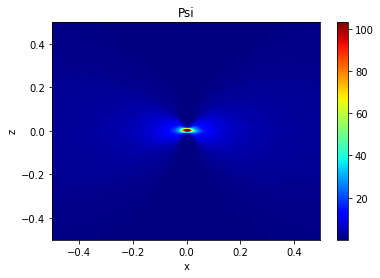

Max Error:  408.98919677734375  Mean Error:  0.12708564377014073


/var/folders/3p/xd5lk7j174n62l9vrjj7hwv40000gn/T/ipykernel_41537/3693503979.py:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(x1, z1, error_mat, cmap='jet')


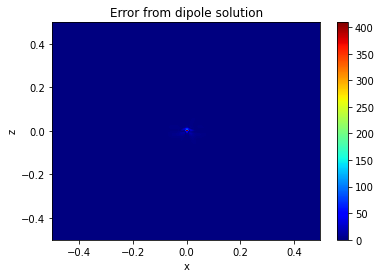

In [52]:
net.eval()

N = 512

small_plot = True
small_size = 0.5

if(small_plot==True):
    x_min = -small_size
    x_max = small_size
    z_min = -small_size
    z_max = small_size
else:
    x_min = -2.0
    x_max = 2.0
    z_min = -2.0
    z_max = 2.0

dx = (x_max - x_min) / N
dz = (z_max - z_min) / N
psi_mat = np.zeros((N,N))
dipole_mat = np.zeros((N,N))

x1 = np.arange(x_min, x_max, dx)
z1 = np.arange(z_min, z_max, dz)
x = np.reshape(x1, (N,1))
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=False).to(device)
for j in range(len(z1)):
    i = z1[j]
    z = np.ones((N,1))*i
    pt_z = Variable(torch.from_numpy(z).float(), requires_grad=False).to(device)
    test_input = torch.cat([pt_x, pt_z],axis=1)
    out = net.forward(test_input)
    psi = out[:,[5]].data.cpu().numpy()
    dipole = (pt_x**2 / ((pt_x**2 + pt_z**2)**(3/2))).data.cpu().numpy()
    psi_mat[j,:] = np.reshape(psi, (N,))
    dipole_mat[j,:] = np.reshape(dipole, (N,))
pcm = plt.pcolormesh(x1, z1, psi_mat, cmap='jet')
plt.title('Psi')
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar(pcm)
plt.show()

error_mat = np.abs(psi_mat - dipole_mat)
print('Max Error: ', np.nanmax(error_mat), ' Mean Error: ', np.nanmean(error_mat))
pcm = plt.pcolormesh(x1, z1, error_mat, cmap='jet')
plt.title('Error from dipole solution')
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar(pcm)
plt.show()

In [ ]:
# Training / Fitting 
iterations = 30000
previous_validation_loss = 99999999.0
lowest_loss = 99999999.0
batch_size = 1000


for tries in range(1):

    for epoch in range(iterations):
        
        optimizer.zero_grad()
        
        if(tries==0 or tries==2):
            # PDE Loss
            x_collocation = np.random.uniform(low=x_min, high=x_max, size=(batch_size,1))
            z_collocation = np.random.uniform(low=z_min, high=z_max, size=(batch_size,1))
            pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
            pt_z_collocation = Variable(torch.from_numpy(z_collocation).float(), requires_grad=True).to(device)
            input_pde = torch.cat([pt_x_collocation, pt_z_collocation], dim=1)
            loss1 = net.PDELoss(input_pde)

        # BC Loss at x = 0
        x_bc = np.zeros((batch_size,1))
        z_bc = np.random.uniform(low=z_min, high=z_max, size=(batch_size,1))
        pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
        pt_z_bc = Variable(torch.from_numpy(z_bc).float(), requires_grad=False).to(device)
        input_bc_x0z = torch.cat([pt_x_bc, pt_z_bc], dim=1)
        loss2 = net.BCLoss_x0z(input_bc_x0z)

        # BC Loss at x = 1
        x_bc = np.ones((batch_size,1))
        z_bc = np.random.uniform(low=z_min, high=z_max, size=(batch_size,1))
        pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=True).to(device)
        pt_z_bc = Variable(torch.from_numpy(z_bc).float(), requires_grad=True).to(device)
        input_bc_x1z = torch.cat([pt_x_bc, pt_z_bc], dim=1)
        loss3 = net.BCLoss_x1z(input_bc_x1z)

        # BC Loss at z = 0
        x_bc = np.random.uniform(low=x_min, high=x_max, size=(batch_size,1))
        z_bc = np.zeros((batch_size,1))
        pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=True).to(device)
        pt_z_bc = Variable(torch.from_numpy(z_bc).float(), requires_grad=True).to(device)
        input_bc_xz0 = torch.cat([pt_x_bc, pt_z_bc], dim=1)
        loss4 = net.BCLoss_xz0(input_bc_xz0)

        # BC Loss at z = close to 0
        x_bc = np.random.uniform(low=x_min, high=x_max, size=(batch_size,1))
        z_bc = np.random.uniform(low=0.0001, high=0.01, size=(batch_size,1))
        pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
        pt_z_bc = Variable(torch.from_numpy(z_bc).float(), requires_grad=False).to(device)
        input_bc_xz0ish = torch.cat([pt_x_bc, pt_z_bc], dim=1)
        loss5 = net.BCLoss_xz0ish(input_bc_xz0ish)

        if(tries==0 or tries==2):
            loss = loss1 + loss2 + loss3 + loss4 + loss5 # PDE + BCs
        else:
            loss = loss2 + loss3 + loss4 + loss5
        # loss = loss2 + loss3 + loss4 + loss5 # BCs only
        
        loss.backward()
        optimizer.step()

        with torch.autograd.no_grad():
            if (((epoch % 10 == 0) and (loss.data < lowest_loss*1.01)) or (epoch%100 == 0)):
                torch.save(net.state_dict(), 'pulsar2D_saved_model.pt')
                print(epoch,"Training Loss:",loss.data)
            elif (epoch % 100 == 0):
                print(epoch,"Training Loss:",loss.data)
            if(lowest_loss > loss.data):
                lowest_loss = loss.data

In [80]:
# Graphing ---- 2D

net.load_state_dict(torch.load('pulsar2D_saved_model.pt'),map_location=device)

# torch.save(net.state_dict(), 'pulsar2D_benchmark.pt')
# torch.save(net.state_dict(), 'mhd_benchmark.pt')
# net.eval()

# x_max=0.2
# z_max=0.2
x_max = 2.0
z_max = 2.0

N = 512
dx = (x_max - x_min) / N
dz = (z_max - z_min) / N
psi_mat = np.zeros((N,N))
Bphi_mat = np.zeros((N,N))
Bpol_mat = np.zeros((N,N))

x1 = np.arange(x_min, x_max, dx)
z1 = np.arange(z_min, z_max, dz)
x = np.reshape(x1, (N,1))
pt_x = Variable(torch.from_numpy(x).float(), requires_grad=False).to(device)
for j in range(len(z1)):
    i = z1[j]
    z = np.ones((N,1))*i
    pt_z = Variable(torch.from_numpy(z).float(), requires_grad=False).to(device)
    test_input = torch.cat([pt_x, pt_z],axis=1)
    out = net.forward(test_input)
    pt_psi = out[:,[5]]
    pt_Bphi = out[:,[3]] # A
    # pt_Bpol = (out[:,[0]]**2 + out[:,[1]]**2)**0.5
    pt_Bpol = out[:,[4]] # Aprime
    psi = pt_psi.data.cpu().numpy()
    Bphi = pt_Bphi.data.cpu().numpy()
    Bpol = pt_Bpol.data.cpu().numpy()
    psi_mat[j,:] = np.reshape(psi, (N,))
    Bphi_mat[j,:] = np.reshape(Bphi, (N,))
    Bpol_mat[j,:] = np.reshape(Bpol, (N,))
pcm = plt.pcolormesh(x1, z1, psi_mat, cmap='jet')
plt.title('Psi')
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar(pcm)
plt.show()

pcm = plt.pcolormesh(x1, z1, Bphi_mat, cmap='jet')
plt.title('B_phi')
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar(pcm)
plt.show()

pcm = plt.pcolormesh(x1, z1, Bpol_mat, cmap='jet')
plt.title('B_pol (Intensity')
plt.xlabel('x')
plt.ylabel('z')
plt.colorbar(pcm)
plt.show()

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.